In [1]:
working_dir = '/mnt/c/users/fordd/Downloads/RW_PGM_FE/'
py_files_dir =  working_dir+'py_files/'
saved_arrays_dir = working_dir+'saved_arrays/'
saved_models_dir = working_dir+'saved_models/'

In [2]:
import os

os.chdir(py_files_dir)

from utils import *
from model import *

os.chdir(working_dir)

In [3]:
get_labels_ = get_2modal_labels_toy_example_
u_ = Local_PE(set_default_reduced_toy_potential_(), get_labels_)

In [4]:
a = 1.3

Zr_s = []
for n_bins in [222]: # np.arange(50,500,10)

    range_x = [-a,a] ; n_bins_x = n_bins
    range_y = [-a,a] ; n_bins_y = n_bins
    range_z = [-a,a] ; n_bins_z = n_bins

    grid_x = np.linspace(range_x[0], range_x[1], n_bins_x) ; dx = grid_x[1] - grid_x[0]
    grid_y = np.linspace(range_y[0], range_y[1], n_bins_y) ; dy = grid_y[1] - grid_y[0]
    grid_z = np.linspace(range_z[0], range_z[1], n_bins_z) ; dz = grid_z[1] - grid_z[0]

    _gr_x, _gr_y = np.meshgrid(grid_x, grid_y)
    gr_x, gr_y, gr_z = np.meshgrid(grid_x, grid_y, grid_z)
    grid_xyz = np.stack([gr_x.flatten(), gr_y.flatten(), gr_z.flatten()]).T

    u_xyz = u_(grid_xyz)

    uxyz = u_xyz.reshape(n_bins_x,n_bins_y,n_bins_z)

    MUxyz = np.exp(-uxyz)
    Zr = MUxyz.sum()*dx*dy*dz ; Zr_s.append(Zr)
    MUxyz /= Zr

    fx = -np.ma.log( (MUxyz*dy*dz).sum((1,2))*Zr )
    fy = -np.ma.log( (MUxyz*dx*dz).sum((0,2))*Zr )
    fz = -np.ma.log( (MUxyz*dx*dy).sum((0,1))*Zr )

    fxy = -np.ma.log( (MUxyz*dz).sum(2)*Zr )
    fxz = -np.ma.log( (MUxyz*dy).sum(1)*Zr )
    fyz = -np.ma.log( (MUxyz*dx).sum(0)*Zr )

    MU_xyz = np.exp(-u_xyz) / Zr

In [5]:
u_xyz.max()

347.73566

In [10]:
# absolute FE of the 3D toy system:
f_system = -np.log(Zr)
f_system # 5.27833

5.278331387757202

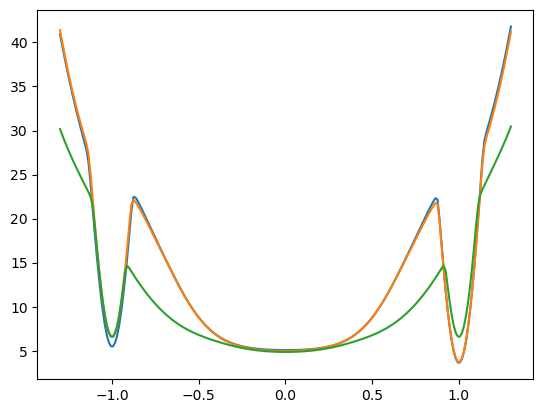

In [11]:
# marginal FEs:
plt.plot(grid_x, fx)
plt.plot(grid_x, fy)
plt.plot(grid_x, fz)

# sample data from the grid

In [24]:
acc = ((MU_xyz/MU_xyz.sum())*80000000).astype(np.int32)
inds_acc = np.where(acc>0)[0]
print(len(inds_acc))

92527


In [25]:
xyz = np.concatenate(
        [np.random.rand(acc[i][0],3)*dx - 0.5*dx + grid_xyz[i:i+1] for i in inds_acc],
         axis=0).astype(np.float32)
print(xyz.shape)
# could crash if too high (memory)
xyz = xyz[np.random.choice(len(xyz),20000000,replace=False)]
print(xyz.shape)

(79938969, 3)
(20000000, 3)


# check dataset sampled ergodically:

In [26]:
pxyz = np.histogramdd(xyz, bins=[n_bins_x,n_bins_y,n_bins_z], range=[range_x,range_y,range_z], density=True)[0]

FES_x = -np.ma.log( pxyz.sum((0,2))*dx*dz ) + f_system
FES_y = -np.ma.log( pxyz.sum((1,2))*dy*dz ) + f_system
FES_z = -np.ma.log( pxyz.sum((0,1))*dx*dy ) + f_system

FES_xy = -np.ma.log( pxyz.sum(2)*dz ).T     + f_system
FES_xz = -np.ma.log( pxyz.sum(0)*dx )       + f_system
FES_yz = -np.ma.log( pxyz.sum(1)*dy )       + f_system

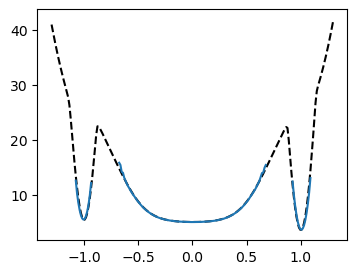

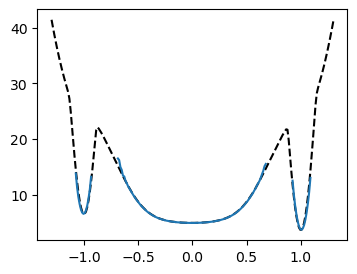

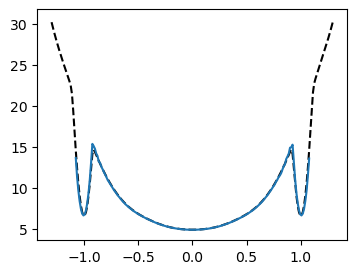

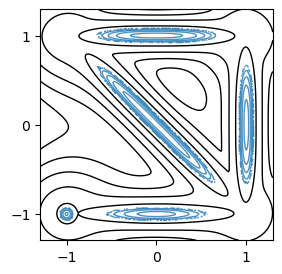

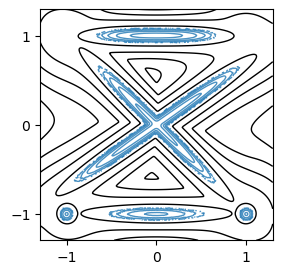

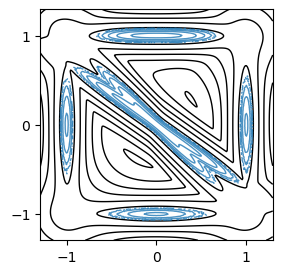

In [27]:
fig = plt.figure(figsize=(4,3))
plt.plot(grid_x,fx,'--',color='black')
plt.plot(grid_x,FES_x)
plt.show()
fig = plt.figure(figsize=(4,3))
plt.plot(grid_y,fy,'--',color='black')
plt.plot(grid_x,FES_y)
plt.show()
fig = plt.figure(figsize=(4,3))
plt.plot(grid_z,fz,'--',color='black')
plt.plot(grid_x,FES_z)
plt.show()

fig= plt.figure(figsize=(3,3))
plt.contour(_gr_x, _gr_y, fxy, 5, linewidths=1, colors='k') 
plt.contour(_gr_x, _gr_y, FES_xy, 5, linewidths=1, colors='C0', alpha=0.8)
plt.yticks([-1,0,1])
plt.show()
fig= plt.figure(figsize=(3,3))
plt.contour(_gr_x, _gr_y, fxz, 5, linewidths=1, colors='k') 
plt.contour(_gr_x, _gr_y, FES_xz, 5, linewidths=1, colors='C0', alpha=0.8)
plt.yticks([-1,0,1])
plt.show()
fig= plt.figure(figsize=(3,3))
plt.contour(_gr_x, _gr_y, fyz, 5, linewidths=1, colors='k') 
plt.contour(_gr_x, _gr_y, FES_yz, 5, linewidths=1, colors='C0', alpha=0.8)
plt.yticks([-1,0,1])
plt.show()

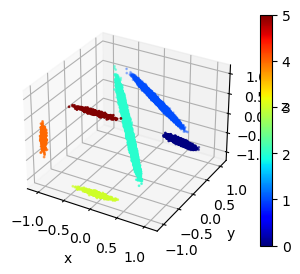

In [28]:
plot_points_(xyz[:50000], get_1modal_labels_toy_example_(xyz[:50000]), s=1)

In [29]:
n_states = 6
labels_grid = get_1modal_labels_toy_example_(grid_xyz)
labels = get_1modal_labels_toy_example_(xyz)

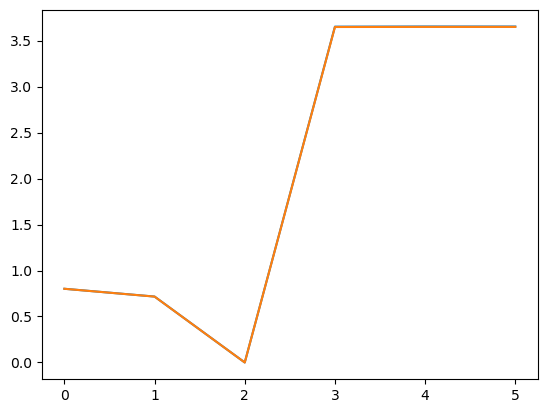

In [30]:
# FE differences between 6 states from populations of samples:

Ns = np.array([np.where(labels==i,1,0).sum() for i in range(n_states)]).astype(np.float32) 
inc_f_data = -np.log(Ns) ; inc_f_data -= inc_f_data.min()

# ground truth abslute FEs of 6 states:

fs_truth = -np.log(np.array([MU_xyz[np.where(labels_grid == i)[0]].sum()*Zr*dx*dy*dz for i in range(n_states)]))

# agreement:

plt.plot(inc_f_data)
plt.plot(fs_truth - fs_truth.min())

# check ergodic in 3 bi-modal states 

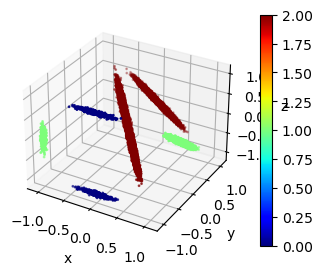

In [31]:
# labeles of the data:
plot_points_(xyz[:50000], get_labels_(xyz[:50000]), s=1)

In [32]:
n_states = 3
labels_grid = get_labels_(grid_xyz)

labels = get_labels_(xyz)
xyz = xyz[np.where(labels!=-1)[0]]
labels = get_labels_(xyz)

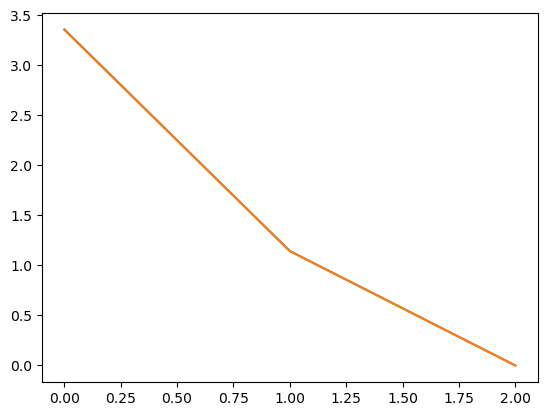

In [33]:
# FE differences between 3 bi-modal states from populations of samples:

Ns = np.array([np.where(labels==i,1,0).sum() for i in range(n_states)]).astype(np.float32) 
inc_f_data = -np.log(Ns) ; inc_f_data -= inc_f_data.min()

# ground truth abslute FEs of 3 bi-modal states:

fs_truth = -np.log(np.array([MU_xyz[np.where(labels_grid == i)[0]].sum()*Zr*dx*dy*dz for i in range(n_states)]))

# agreement:

plt.plot(inc_f_data)
plt.plot(fs_truth - fs_truth.min())

In [34]:
print('ground truth absolute FEs of states:\n',fs_truth,

-np.log(np.array([MU_xyz[np.where(labels_grid == i)[0]].sum()*Zr*dx*dy*dz for i in range(n_states)])))

print('ground truth FE differences between states:\n',fs_truth - fs_truth.min())
print('ground truth absolute FE of system:\n', f_system)

ground truth absolute FEs of states:
 [8.93431652 6.72405548 5.5813567 ] [8.93431652 6.72405548 5.5813567 ]
ground truth FE differences between states:
 [3.35295982 1.14269877 0.        ]
ground truth absolute FE of system:
 5.278331387757202


In [35]:
# ground truth average potential energies of the 3 states:
us_truth = np.array([pool_(u_xyz[np.where(labels_grid == i)[0]],MU_xyz[np.where(labels_grid == i)[0]]) for i in range(n_states)])
us_truth

array([3.9952977, 1.8498286, 1.4479853], dtype=float32)

# prepare other parts of dataset

In [37]:
print(n_states) # 3

# indices of metastable states in all data
inds_states = [np.where(labels == i)[0] for i in range(n_states)]
counts_states = [len(x) for x in inds_states]

# reduced potential energies of all data:
u = u_(xyz)

# relative a priori weights of all data:
metaD_weights = np.ones([len(u),1]) # uniform weights (unbiased data)

3


In [54]:
# average potential energies of the three states based on samples:
[u[inds_states[k]].mean() for k in range(3)]

[4.0027356, 1.8771924, 1.4787772]

In [39]:
# for shifting scaling xyz to and from model range [-1,1]
ic_map = XR_MAP_toy(xyz[:1])
ic_map.data_ranges = [[-1.4, 1.4], [-1.4, 1.4], [-1.4, 1.4]]

small round off error coming from tf : ignored

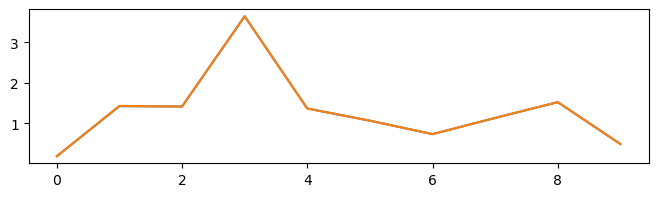

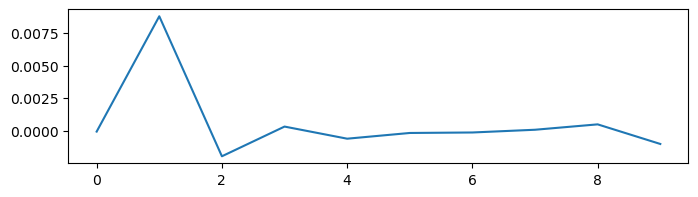

In [41]:
fig = plt.figure(figsize=(8,2))
plt.plot(u_(xyz)[:10])
plt.plot(u_(xyz[:10]))
plt.show()
fig = plt.figure(figsize=(8,2))
plt.plot(u_(xyz[:10]) - u_(xyz)[:10]) # ignored
plt.show()

True


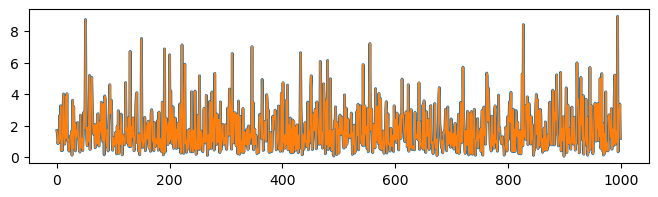

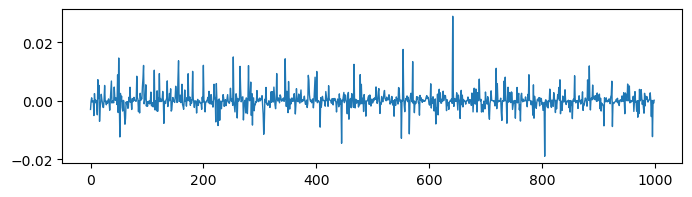

In [42]:
N_total = xyz.shape[0]
rand_inds = np.random.choice(N_total,1000,replace=False)
fig = plt.figure(figsize=(8,2))
plt.plot(u_(xyz[rand_inds]), linewidth=2)
plt.plot(u[rand_inds], linewidth=1)
print(np.allclose(u_(xyz[rand_inds]), u[rand_inds], atol=1e-1)) # 1e-1 !!
plt.show()
fig = plt.figure(figsize=(8,2))
plt.plot(u[rand_inds] - u_(xyz[rand_inds]), linewidth=1)
plt.show()

In [43]:
print('counts_states:',counts_states)
training_set_size = min(counts_states)//2
print('size of the training and validation sets:', training_set_size)

counts_states: [514765, 4710703, 14774471]
size of the training and validation sets: 257382


In [44]:
av_u_GT0 = np.array([u[inds_states[k]].mean() for k in range(n_states)])
av_u_GT0 -= av_u_GT0.min()

Want training_set_size number of datapoints from each state to make a training set.
Want training_set_size number of other datapoints from each state to make a validation set.
Want both training and validation sets to have similar average potential energies as the more reliable averages over all available data (av_u_GT0).

2 : 0.0009460305719381176


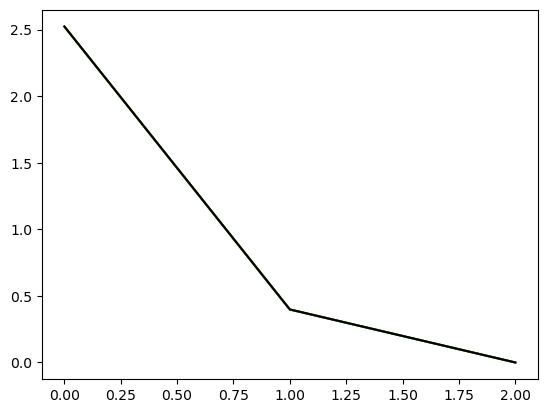

In [45]:
#'''
done = False
for i in range(1000):
    if not done:
        _inds_rand = None
        training, validation, _inds_rand = split_into_training_data_(xyz,
                                                                     u,
                                                                     metaD_weights,
                                                                     labels = labels,
                                                                     training_set_size = training_set_size,
                                                                     inds_rand = _inds_rand,
                                                                    )
        xyz_training, u_training, w_training = training
        xyz_validation, u_validation, w_validation = validation
        del training, validation 
        
        # weights only relevant within each state.
        w_training = [x/x.sum() for x in w_training]
        w_validation = [x/x.sum() for x in w_validation]

        ##

        av_u_T = np.array([pool_(u_training[k],w_training[k]) for k in range(n_states)])
        av_u_T -= av_u_T.min()
        av_u_V = np.array([pool_(u_validation[k],w_validation[k]) for k in range(n_states)])
        av_u_V -= av_u_V.min()
        av_u_GT = (av_u_V+av_u_T)*0.5
        av_u_GT -= av_u_GT.min()
        ##
        err = (np.linalg.norm(av_u_GT0-av_u_GT) + np.linalg.norm(av_u_GT0-av_u_T) + np.linalg.norm(av_u_GT0-av_u_V) )/3
        if err <= 0.002:
            done = True
            print(i,':',err)
        else: done = False

plt.plot(av_u_T)
plt.plot(av_u_V)
plt.plot(av_u_GT)
plt.plot(av_u_GT0 - av_u_GT0.min(),color='black')
#'''

# Intentionally choosing a very small number of training and validation datapoints (only 1000)

In [46]:
small_training_set_size = 1000

0 : 0.007258445731931959 < 0.02


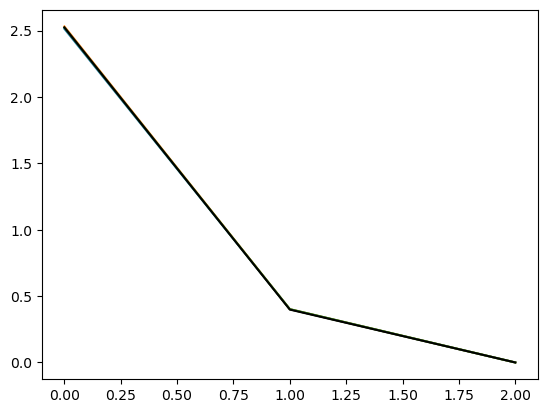

In [47]:
done = False
for i in range(1000):
    if not done:
        '''
        _inds_rand = None
        training, validation, _inds_rand = split_into_training_data_(xyz,u,metaD_weights,
                                            labels=labels,
                                            training_set_size = small_training_set_size,
                                            inds_rand = _inds_rand)
        small_xyz_training, small_u_training, small_w_training = training
        small_xyz_validation, small_u_validation, small_w_validation = validation
        del training, validation 
        '''
        # this took many iterations to land with small error:
        small_xyz_training, small_u_training, small_w_training, small_xyz_validation, small_u_validation, small_w_validation = load_pickle_(saved_arrays_dir+'toy_example_lucky_1000')
        
        small_w_training = [x/x.sum() for x in small_w_training]
        small_w_validation = [x/x.sum() for x in small_w_validation]

        ##
        av_u_T = np.array([pool_(small_u_training[k],small_w_training[k]) for k in range(n_states)])
        av_u_T -= av_u_T.min()
        av_u_V = np.array([pool_(small_u_validation[k],small_w_validation[k]) for k in range(n_states)])
        av_u_V -= av_u_V.min()
        av_u_GT = (av_u_V+av_u_T)*0.5
        av_u_GT -= av_u_GT.min()
        ##
        err = (np.linalg.norm(av_u_GT0-av_u_GT) + np.linalg.norm(av_u_GT0-av_u_T) + np.linalg.norm(av_u_GT0-av_u_V) )/3
        if err <= 0.02 :
            done = True
            print(i,':',err,'<',0.02)
        else: 
            done = False
            print(i,':',err)

plt.plot(av_u_T)
plt.plot(av_u_V)
plt.plot(av_u_GT)
plt.plot(av_u_GT0 - av_u_GT0.min(),color='black')


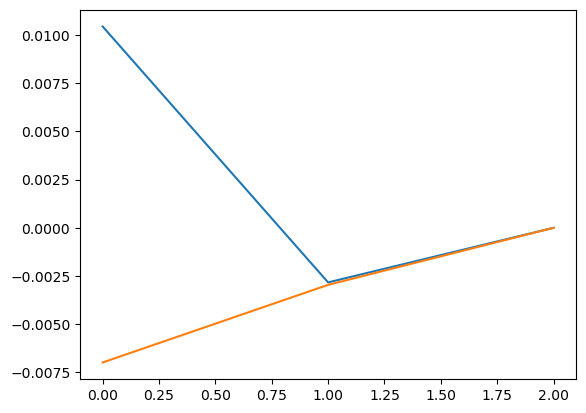

In [53]:
plt.plot( av_u_GT0-av_u_T )
plt.plot( av_u_GT0-av_u_V )

In [49]:
#save_pickle_([small_xyz_training, small_u_training, small_w_training,
#              small_xyz_validation, small_u_validation, small_w_validation,
#             ], saved_arrays_dir+'toy_example_lucky_1000')

saved toy_example_lucky_1000


checking everything ready:

In [55]:
print(av_u_T)
print(av_u_V)
print(av_u_GT)
print(av_u_GT0)

[2.51351764 0.40124641 0.        ]
[2.53094289 0.4013747  0.        ]
[2.52223026 0.40131056 0.        ]
[2.5239584 0.3984152 0.       ]


In [56]:
print([pool_(small_u_training[k],small_w_training[k]) for k in range(n_states)])
print([pool_(small_u_validation[k],small_w_validation[k]) for k in range(n_states)])
print([u[inds_states[k]].mean() for k in range(n_states)])

[3.9743745925426497, 1.8621033681035046, 1.4608569553717974]
[4.023419147968293, 1.8938509558141237, 1.4924762577414517]
[4.0027356, 1.8771924, 1.4787772]


In [57]:
print([x.shape for x in xyz_training])
print([x.shape for x in xyz_validation])

print([x.shape for x in u_training])
print([x.shape for x in u_validation])

print([x.shape for x in w_training])
print([x.shape for x in w_validation])

[(257382, 3), (257382, 3), (257382, 3)]
[(257382, 3), (257382, 3), (257382, 3)]
[(257382, 1), (257382, 1), (257382, 1)]
[(257382, 1), (257382, 1), (257382, 1)]
[(257382, 1), (257382, 1), (257382, 1)]
[(257382, 1), (257382, 1), (257382, 1)]


In [58]:
print([x.shape for x in small_xyz_training])
print([x.shape for x in small_xyz_validation])

print([x.shape for x in small_u_training])
print([x.shape for x in small_u_validation])

print([x.shape for x in small_w_training])
print([x.shape for x in small_w_validation])

[(1000, 3), (1000, 3), (1000, 3)]
[(1000, 3), (1000, 3), (1000, 3)]
[(1000, 1), (1000, 1), (1000, 1)]
[(1000, 1), (1000, 1), (1000, 1)]
[(1000, 1), (1000, 1), (1000, 1)]
[(1000, 1), (1000, 1), (1000, 1)]


In [59]:
inds_rand = np.random.choice(training_set_size,100,replace=False)

for _x,_u in zip(xyz_training, u_training):
    print(np.allclose(u_(_x[inds_rand]),_u[inds_rand], atol=1e-1))
    
k=0
for _x,_u in zip(xyz_training, u_training):
    print(np.allclose(u_(_x[inds_rand],k=k),_u[inds_rand], atol=1e-1))
    k+=1
    
for _x,_u in zip(xyz_validation, u_validation):
    print(np.allclose(u_(_x[inds_rand]),_u[inds_rand], atol=1e-1))
    
k=0
for _x,_u in zip(xyz_validation, u_validation):
    print(np.allclose(u_(_x[inds_rand],k=k),_u[inds_rand], atol=1e-1))
    k+=1
    
inds_rand = np.random.choice(small_training_set_size,100,replace=False)

for _x,_u in zip(small_xyz_training, small_u_training):
    print(np.allclose(u_(_x[inds_rand]),_u[inds_rand], atol=1e-1))
    
k=0
for _x,_u in zip(small_xyz_training, small_u_training):
    print(np.allclose(u_(_x[inds_rand],k=k),_u[inds_rand], atol=1e-1))
    k+=1
    
for _x,_u in zip(small_xyz_validation, small_u_validation):
    print(np.allclose(u_(_x[inds_rand]),_u[inds_rand], atol=1e-1))
    
k=0
for _x,_u in zip(small_xyz_validation, small_u_validation):
    print(np.allclose(u_(_x[inds_rand],k=k),_u[inds_rand], atol=1e-1))
    k+=1

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [60]:
PM = [0,0,0]
flow_masks = get_list_cond_masks_unsupervised_(len(PM))
flow_masks

[array([0, 1, 0]), array([0, 0, 1])]

In [61]:
flow_masks = np.eye(3).astype(np.int32)
flow_masks

array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]], dtype=int32)

In [62]:
ic_map.n_atoms = 1

In [63]:
learning_rate = 0.001
rate_decay = 0.0

In [64]:
for k in range(n_states):
    globals()['model_'+str(k)] = MODEL_3(
                                    periodic_mask = PM,
                                    list_cond_masks = flow_masks,
                                    IC_map = ic_map,
                                    optimiser_LR_decay = [learning_rate, rate_decay],

                                    n_bins_periodic = 8,
                                    number_of_splines_periodic = 2,
                                    n_bins_other = 8,

                                    n_hidden = 1,
                                    hidden_activation = tf.nn.silu,
                                    min_bin_width = 1e-3,
                                    trainable_slopes = True,
                                    min_knot_slope = 1e-3,
                                    dims_hidden = [100,100,100],
                                    nk_for_periodic_MLP_encoding = 1,
                                    )
# 143607

There are 143607 trainable parameters in this model, among 48 trainable_variables.
[NB: To see dimensionalities of the trainable variables print(list(self.shapes_trainable_variables)).] 
There are 143607 trainable parameters in this model, among 48 trainable_variables.
[NB: To see dimensionalities of the trainable variables print(list(self.shapes_trainable_variables)).] 
There are 143607 trainable parameters in this model, among 48 trainable_variables.
[NB: To see dimensionalities of the trainable variables print(list(self.shapes_trainable_variables)).] 


In [65]:
trainer = TRAINER(models = [globals()['model_'+str(k)] for k in range(n_states)],
        max_training_batches = 15000,
        n_batches_between_evaluations = 50,
       )

In [66]:
delta_f_ground_truth = fs_truth - fs_truth.min()

FE estimates of state 2 (often the lowest FE) moved to around 0
FE estimates of state 2 (often the lowest FE) moved to around 0
FE estimates of state 2 (often the lowest FE) moved to around 0
FE estimates of state 2 (often the lowest FE) moved to around 0


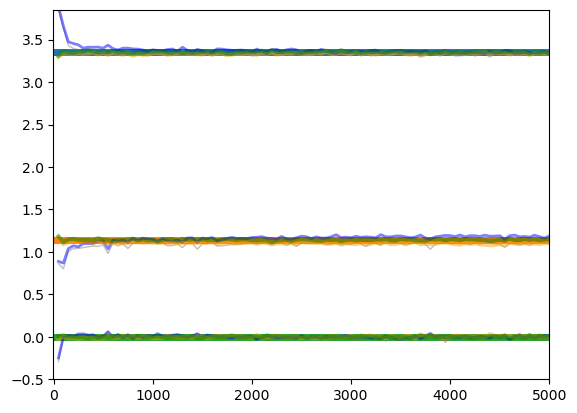

In [50]:
trainer.train(
            n_batches = 5000,
    
            training_batch_size = 1000,
            evalation_batch_size = small_training_set_size,
    
            xyz_training = small_xyz_training,
            u_training = small_u_training,
            xyz_validation = small_xyz_validation,
            u_validation = small_u_validation,
    
            potential_energy_function = u_,
            
            delta_f_ground_truth = delta_f_ground_truth,
            
            evaluate_main = True,
            f_window_grain_BAR_local = [-20,20,2000],
            shuffle = True,
    
            name_save_BAR_inputs = saved_arrays_dir+'toy_BAR_inputs_III',
            name_save_mBAR_inputs = saved_arrays_dir+'toy_MBAR_inputs_III',
)

In [69]:
for k in range(n_states):
    globals()['model_'+str(k)].replace_paremeters(globals()['model_'+str(k)].initial_parameters)
    globals()['model_'+str(k)].reset_optimiser([learning_rate, rate_decay])
trainer.models = [globals()['model_'+str(k)] for k in range(n_states)]

FE estimates of state 2 (often the lowest FE) moved to around 0
FE estimates of state 2 (often the lowest FE) moved to around 0
FE estimates of state 2 (often the lowest FE) moved to around 0
FE estimates of state 2 (often the lowest FE) moved to around 0


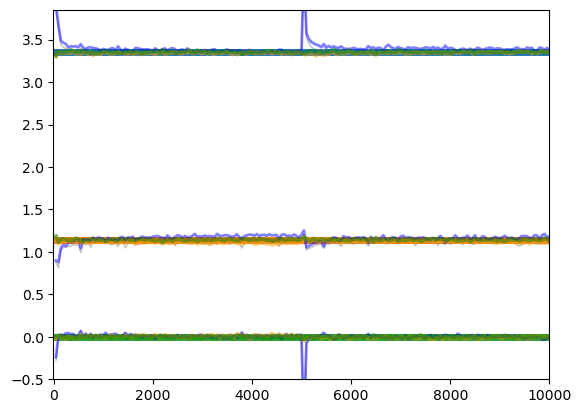

In [52]:
trainer.train(
            n_batches = 5000,
    
            training_batch_size = 1000,
            evalation_batch_size = small_training_set_size,
    
            xyz_training = small_xyz_validation,
            u_training = small_u_validation,
            xyz_validation = small_xyz_training,
            u_validation = small_u_training,
    
            potential_energy_function = u_,
            
            delta_f_ground_truth = delta_f_ground_truth,
            
            evaluate_main = True,
            f_window_grain_BAR_local = [-20,20,2000],
            shuffle = True,
    
            name_save_BAR_inputs = saved_arrays_dir+'toy_BAR_inputs_III',
            name_save_mBAR_inputs = saved_arrays_dir+'toy_MBAR_inputs_III',
)

In [53]:
#trainer.save_the_above_(saved_arrays_dir+'toy_est_grid_AVall_III')

saved toy_est_grid_AVall_III


In [54]:
#for k in range(n_states):
#    globals()['model_' + str(k)].save_model(saved_models_dir+'model_'+str(k)+'_toy_III')

saved model_0_toy_III
saved model_1_toy_III
saved model_2_toy_III


In [ ]:
## results plotted in a different notebook 'toy_example_3D_mBAR'

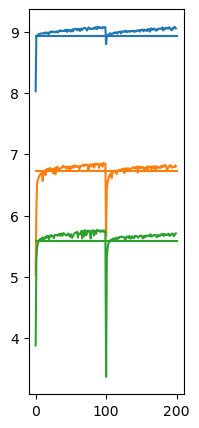

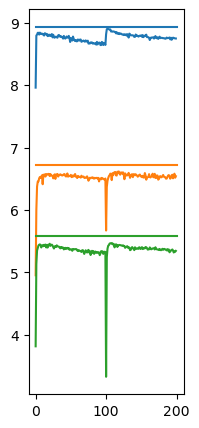

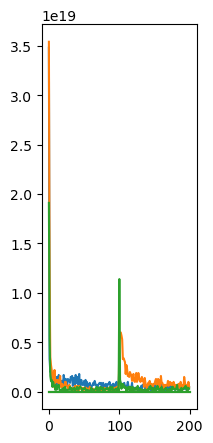

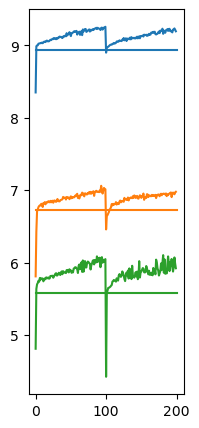

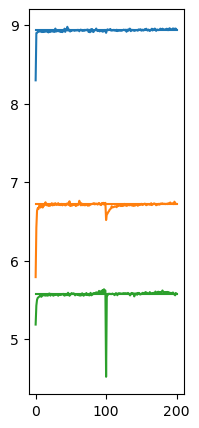

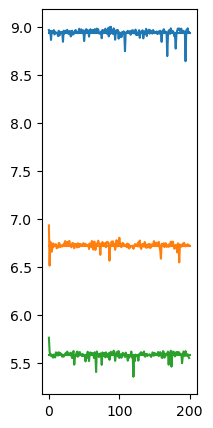

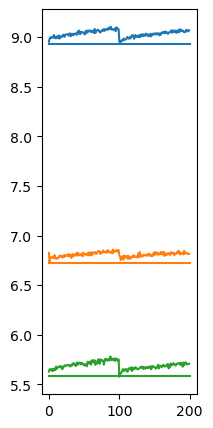

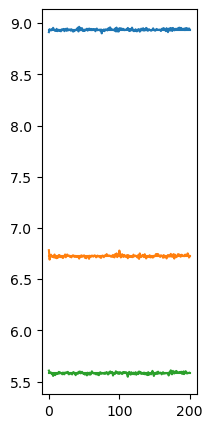

In [58]:
for i in range(8):
    fig = plt.figure(figsize=(2,5))
    plt.plot(trainer.estimates[:,:,i].T)
    [plt.plot([0,200],[fs_truth[k]]*2,color='C'+str(k)) for k in range(n_states)]
    plt.show()

In [59]:
rs = []
negS_BGs = []
for k in range(n_states):
    r_samples, negS_BG = trainer.models[k].sample_model(256241)
    rs.append(r_samples)
    negS_BGs.append(negS_BG)

In [60]:
import matplotlib 
matplotlib.rc('xtick', labelsize=10) 
matplotlib.rc('ytick', labelsize=10) 

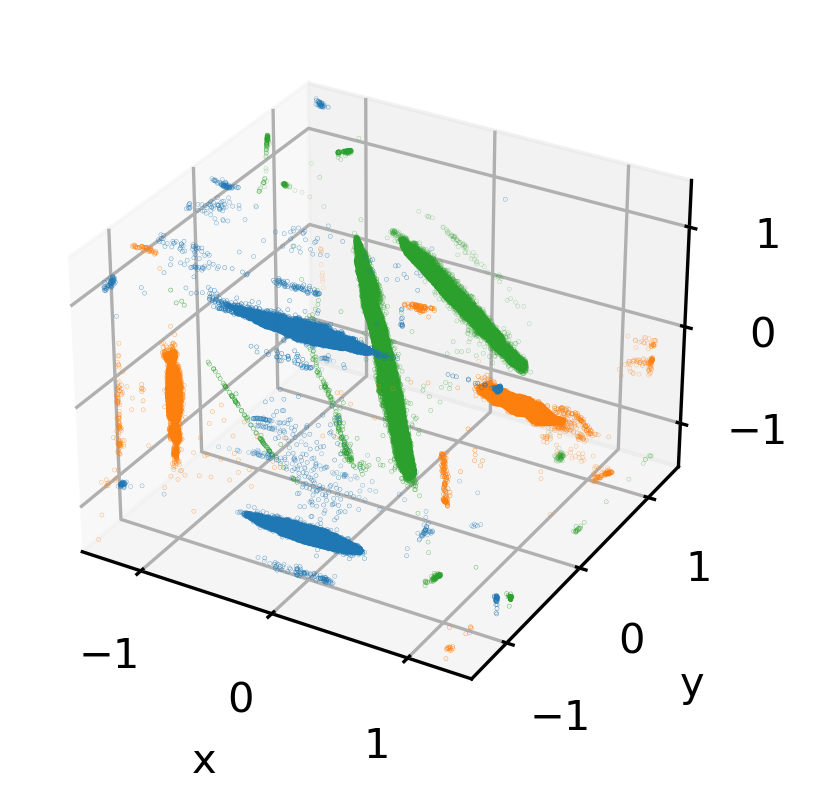

In [70]:
fig = plt.figure(figsize=(5,3),dpi=300)
ax = fig.add_subplot(111, projection='3d')
for k in range(n_states):
    ax.scatter(rs[k][:,0],rs[k][:,1],rs[k][:,2],s=0.01,color='C'+str(k))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_xlim(-1.4, 1.4)
ax.set_ylim(-1.4, 1.4)
ax.set_zlim(-1.4, 1.4)
ax.set_xticks([-1, 0, 1])
ax.set_yticks([-1, 0, 1])
ax.set_zticks([-1, 0, 1])
plt.show()

In [ ]:
# how it should ideally look:

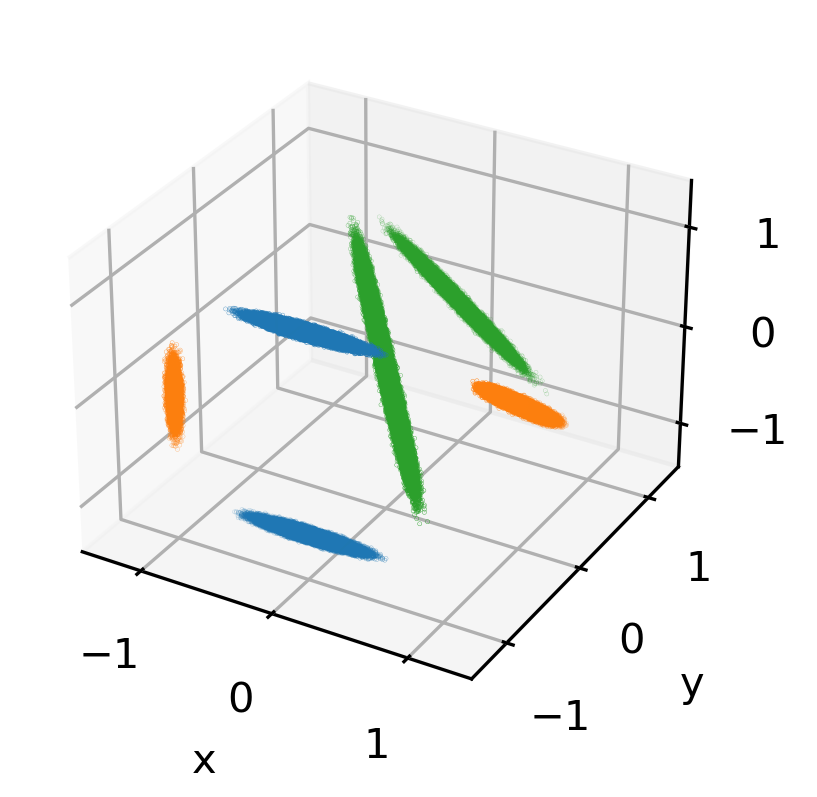

In [74]:
fig = plt.figure(figsize=(5,3),dpi=300)
ax = fig.add_subplot(111, projection='3d')
for k in range(n_states):
    ax.scatter(xyz_training[k][:,0],xyz_training[k][:,1],xyz_training[k][:,2],s=0.01,color='C'+str(k))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_xlim(-1.4, 1.4)
ax.set_ylim(-1.4, 1.4)
ax.set_zlim(-1.4, 1.4)
ax.set_xticks([-1, 0, 1])
ax.set_yticks([-1, 0, 1])
ax.set_zticks([-1, 0, 1])
plt.show()